In [1]:
# dependecies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ETS
from statsmodels.tools.eval_measures import mse
from statsmodels.tools.eval_measures import meanabs

In [2]:
# filepath
path_1 = "Data/BicycleSales_2015-20211021_Cleaned.xlsx"
path_2 = "Data/BikeSpecs.xlsx"

# read data
sales_df = pd.read_excel(path_1)
specs_df = pd.read_excel(path_2)

In [3]:
# rename specs Object column to Material
specs1_df = specs_df.rename(columns={"Object":"Material"})

# merge specs into sales data frame
merged_df = pd.merge(sales_df, specs1_df, on="Material", how="left")

In [4]:
# reduce down to necessary columns
reduced_df = merged_df[["Material", "Sold-to pt", "Month", "Invoiced Quantity", 
                        "Product hierarchy.1", "Application_x", "Tire Size", "Ply Construction",
                        "Bead", "Color", "TPI - Threads per inch", "Compound", "Technology"
                       ]]

# rename columns
reduced_df = reduced_df.rename(columns={"Product hierarchy.1":"Product hierarchy",
                                        "Application_x":"Application"})

# split tire size by diameter (before x) and width (after x)
reduced_df[["Diameter", "Width"]] = reduced_df["Tire Size"].str.split("X", n=1, expand=True)

# splite Month into separate month and year components
reduced_df[["Month", "Year"]] = reduced_df["Month"].str.split("/", n=1, expand=True)

# create Date column with reordered Year/Date format
reduced_df["Date"] = reduced_df["Year"] + "/" + reduced_df["Month"]

# strip erroneous text from diameter and width
reduced_df["Diameter"] = reduced_df["Diameter"].str.replace(r'"','')
reduced_df["Width"] = reduced_df["Width"].str.replace(r'"','')

# drop application Tubes and MVS
reduced_df = reduced_df[reduced_df["Application"].str.contains("TUBE|MVS")==False]

#Displaying Cleaned Dataframe
reduced_df

# Output to excel for review
# reduced_df.to_excel('Output/output.xlsx')

,Material,Sold-to pt,Month,Invoiced Quantity,Product hierarchy,Application,Tire Size,Ply Construction,Bead,Color,TPI - Threads per inch,Compound,Technology,Diameter,Width,Year,Date
0,TB29688100,1025073,01,1,M143 CREEPY CRAWLER,MODIFIED TRIALS,20X2.00,Single Ply,Wire,Black,60,Super Tacky,ST,20,2.00,2015,2015/01
1,TB73301000,1025073,01,6,M147 DTH,URBAN,26X2.30,Single Ply,Foldable,Black,60,Single,,26,2.30,2015,2015/01
2,TB96802000,1025073,01,2,M148 GRIFTER,URBAN,29X2.50,Single Ply,Wire,Black,60,Single,,29,2.50,2015,2015/01
3,TB96651200,1025073,01,2,M149 TORCH,URBAN,29X2.10,Single Ply,Foldable,Black,120,Single,SilkWorm,29,2.10,2015,2015/01
4,TB35790100,1025073,01,0,M151 SNYPER,BMX,20X2.25,Single Ply,Foldable,Black,60,Dual,EXO,20,2.25,2015,2015/01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77561,TB00241300,1035759,10,2,M357RU Dissector,MOUNTAIN,29X2.40,Single Ply,Foldable,Black,60,Dual,EXO/TR,29,2.40,2021,2021/10
77562,TB00200500,1035815,10,1,M2018RU RAMBLER,DIRT ROAD/GRAVEL,700X40,Single Ply,Foldable,Black,60,Dual,SilkShield/TR,700,40,2021,2021/10
77563,TB00241300,1035905,10,2,M357RU Dissector,MOUNTAIN,29X2.40,Single Ply,Foldable,Black,60,Dual,EXO/TR,29,2.40,2021,2021/10
77564,TB91145000,1035908,10,2,M349 Rekon,MOUNTAIN,27.5X2.60,Single Ply,Foldable,Black,120,3C Maxx Terra,3CT/EXO/TR,27.5,2.60,2021,2021/10


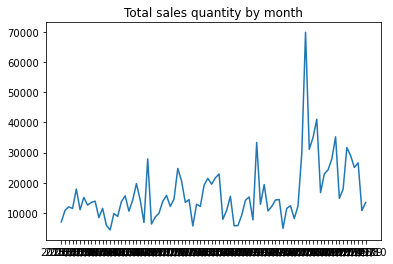

<Figure size 432x288 with 0 Axes>

In [5]:
# group by material create a time series for each material for invoiced quantity by month
# diameter_df = reduced_df.groupby(["Diameter"])[["Diameter", "Month", "Invoiced Quantity"]]
# month_df = reduced_df.groupby(["Month"])[["Month", "Invoiced Quantity"]]
date_df = reduced_df.groupby(["Date"], as_index = False)[["Date", "Invoiced Quantity"]].sum()                     

# Prelimiary plot to quickly visualize overall
plt.plot(date_df["Date"], date_df["Invoiced Quantity"])
plt.title("Total sales quantity by month")

plt.show()
plt.savefig("Output/Total sales quantity by month.png")

In [6]:
# group by year and month then sum invoiced quantity
year_month_df = reduced_df.groupby(["Year", "Month"],
                                   as_index = False)[["Year", "Month", "Invoiced Quantity"]].sum()

year_month_df

,Year,Month,Invoiced Quantity
0,2015,01,7033
1,2015,02,10889
2,2015,03,12035
3,2015,04,11476
4,2015,05,17951
...,...,...,...
77,2021,06,28994
78,2021,07,25092
79,2021,08,26621
80,2021,09,10798


C:\Users\iamth\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\iamth\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\iamth\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-7-2cde67b77fb4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc1519_df["Forecast"] = ETS(fc1519_df["Invoiced Quantity"],
<ipython-input-7-2cde67b77fb4>:21: SettingWithCopyWarning: 
A value is trying to be set on

MSE: 23465694.35
MAE: 3503.2166666666667


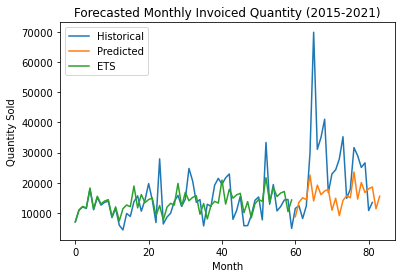

In [7]:
# Holt Winters ETS forecasting

fc_df = year_month_df

fc1519_df = fc_df.loc[(fc_df['Year'] == "2015")|
          (fc_df['Year'] == "2016")|
          (fc_df['Year'] == "2017")|
          (fc_df['Year'] == "2018")|
          (fc_df['Year'] == "2019"), :]

fit_model = ETS(fc1519_df["Invoiced Quantity"],
                           trend="mul",seasonal="mul",
                           seasonal_periods=12).fit()

fc2021 = fit_model.forecast(24).round()

fc1519_df["Forecast"] = ETS(fc1519_df["Invoiced Quantity"],
                           trend="mul",seasonal="mul",
                           seasonal_periods=12).fit().fittedvalues

fc1519_df["Forecast"] = fc1519_df["Forecast"].round()

# plot the forecasted model
fc_df["Invoiced Quantity"].plot(legend=True, label="Historical")
fc2021.plot(legend=True, label="Predicted")
fc1519_df["Forecast"].plot(legend=True, label="ETS",
                          title="Forecasted Monthly Invoiced Quantity (2015-2021)",
                          ylabel="Quantity Sold",
                          xlabel="Month")

plt.savefig("Output/Forecasted Quantity by Month.png")

# mean squared error and mean average error
mse_test = mse(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])
mae_test = meanabs(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])

# append forecasted values onto onto model
fc1521_df = pd.DataFrame({"Forecast": fc1519_df["Forecast"].append(fc2021)})

# merge forecasted dataframe with actual sales data frame
fcm_df = fc_df.merge(fc1521_df, how='outer', left_index=True, right_index=True)

fcm_df.at[82,"Year"]= "2021"
fcm_df.at[83,"Year"]= "2021"
fcm_df.at[82,"Month"]= "11"
fcm_df.at[83,"Month"]= "12"

print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")

In [8]:
# Group forecasts by year
fcm_yr_df = fcm_df.groupby(["Year"],
                           as_index = False)[["Year","Invoiced Quantity","Forecast"]].sum()

fcm_yr_df.to_csv("Output/forecast_by_year.csv", index = False)

fcm_yr_df

,Year,Invoiced Quantity,Forecast
0,2015,145656.0,149113.0
1,2016,152066.0,154639.0
2,2017,160371.0,161912.0
3,2018,175695.0,170569.0
4,2019,168569.0,177373.0
5,2020,315350.0,184502.0
6,2021,232646.0,192619.0


In [9]:
#chi testing data from combined_year
forcast_chi = {'year': ['2020','2021'],
         'expected': [184502,192619], 'observed':[168569,315350]}

forcast_chi_df = pd.DataFrame(forcast_chi)

forcast_chi_df.to_csv("Output/forcast_chi_df.csv", index = False)

forcast_chi_df

,year,expected,observed
0,2020,184502,168569
1,2021,192619,315350


In [10]:
critical_value = st.chi2.ppf(q = 0.95, df = 2)
critical_value

5.991464547107979

In [11]:
st.chisquare(forcast_chi_df['observed'], forcast_chi_df['expected'])

Power_divergenceResult(statistic=79576.40323390791, pvalue=0.0)

In [12]:
# Find years and months, 
# create a dataframe containing the summed quantities for each date 
# with months in rows and years in columns

years = year_month_df["Year"].unique()
months = {"Month": year_month_df["Month"].unique()}
yearly_df = pd.DataFrame(months)

for each in years:
    df = year_month_df.loc[year_month_df['Year'] == each]
    df = df[["Month","Invoiced Quantity"]]
    df = df.rename(columns={"Invoiced Quantity" : each})
    yearly_df = pd.merge(yearly_df, df, on="Month", how="left" )      

yearly_df

,Month,2015,2016,2017,2018,2019,2020,2021
0,01,7033,5910,6349,12896,9199,11519,27922.0
1,02,10889,4379,8625,12168,14199,12394,35276.0
2,03,12035,9826,9919,19219,15306,8156,14860.0
3,04,11476,8848,13838,21474,7709,12339,17904.0
4,05,17951,13763,15824,19552,33378,29773,31690.0
5,06,11066,15669,12179,21651,12894,69930,28994.0
6,07,15160,10593,14596,22923,19419,31108,25092.0
7,08,12611,14253,24757,7888,10685,35025,26621.0
8,09,13517,19745,20615,10848,12128,41086,10798.0
9,10,13919,14311,13531,15516,14318,16750,13489.0


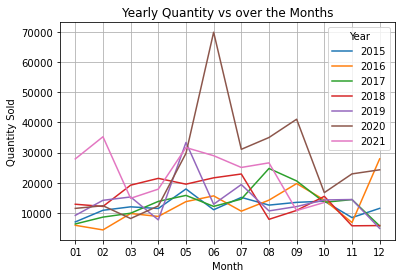

<Figure size 432x288 with 0 Axes>

In [13]:
# plot quantity by month for each year
for each in years:
    plt.plot(yearly_df["Month"], yearly_df[each], label = each)

plt.title("Quantity Sold by Month")
plt.xlabel("Month")
plt.ylabel("Quantity Sold")
plt.legend(title="Year")
plt.title("Yearly Quantity vs over the Months")
plt.grid()
plt.show()

plt.savefig("Output/Yearly Quantity vs over the Months.png")

In [14]:
#using .groupby() and .sum() to get the year to invoiced quantity total
combined_year = year_month_df.groupby(['Year'])['Invoiced Quantity'].sum().reset_index()
combined_year

,Year,Invoiced Quantity
0,2015,145656
1,2016,152066
2,2017,160371
3,2018,175695
4,2019,168569
5,2020,315350
6,2021,232646


In [15]:
#dropping year 2020 and 2021 during the covid year before calculating lineregression.
combined_year_drop = combined_year.drop([5,6])
combined_year_drop

,Year,Invoiced Quantity
0,2015,145656
1,2016,152066
2,2017,160371
3,2018,175695
4,2019,168569


The r-squared is: 0.821
y = 6945.5 x + -13848602.1


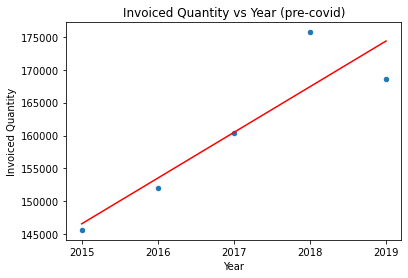

In [16]:
#setting up the linear regression and line for the scatter plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(combined_year_drop["Year"].astype(int),combined_year_drop["Invoiced Quantity"])

#arithmatic for regression
regression_value = combined_year_drop["Year"].astype(int) * slope + intercept
#writing out the linear equation to print into the scatter plot
linear_equ = f"y = {round(slope, 2)} x + {round(intercept, 2)}"

#Plotting the figure and adding the line
combined_year_drop.plot.scatter(x='Year', y='Invoiced Quantity')
plt.plot(combined_year_drop['Year'], regression_value, color='r')

print(f"The r-squared is: {round(rvalue**2,3)}")
print(f"y = {round(slope, 2)} x + {round(intercept, 2)}")
plt.title("Invoiced Quantity vs Year (pre-covid)")
plt.savefig("Output/Invoiced Quantity vs Year (pre-covid).png")
plt.show()

The r-squared is: 0.565
y = 21276.29 x + -42742637.0


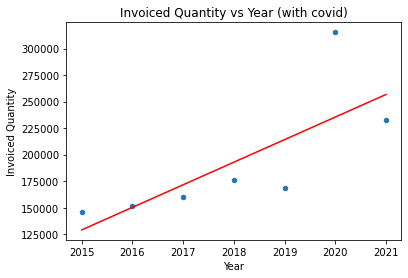

In [17]:
#setting up the linear regression and line for the scatter plot for 7 years including covid
(slope, intercept, rvalue, pvalue, stderr) = linregress(combined_year["Year"].astype(int),combined_year["Invoiced Quantity"])

#arithmatic for regression
regression_value = combined_year["Year"].astype(int) * slope + intercept
#writing out the linear equation to print into the scatter plot
linear_equ = f"y = {round(slope, 2)} x + {round(intercept, 2)}"

#Plotting the figure and adding the line
combined_year.plot.scatter(x='Year', y='Invoiced Quantity')
plt.plot(combined_year['Year'], regression_value, color='r')

print(f"The r-squared is: {round(rvalue**2,3)}")
print(f"y = {round(slope, 2)} x + {round(intercept, 2)}")
plt.title("Invoiced Quantity vs Year (with covid)")
plt.savefig("Output/Invoiced Quantity vs Year (with covid).png")
plt.show()

In [18]:
# quantity sold grouped by application

application_df = reduced_df.groupby(["Application","Year"],
                                   as_index = False)[["Application","Year","Invoiced Quantity"]].sum()

years = application_df["Year"].unique()
applications = {"Application": application_df["Application"].unique()}
application_year_df = pd.DataFrame(applications)

for each in years:
    df = application_df.loc[application_df['Year'] == each]
    df = df[["Application","Invoiced Quantity"]]
    df = df.rename(columns={"Invoiced Quantity" : each})
    application_year_df = pd.merge(application_year_df, df, on="Application", how="left" )      

application_year_df

,Application,2015,2016,2017,2018,2019,2020,2021
0,BMX,14526.0,10365.0,8591,6116,4856,7523,6566
1,CYCLOCROSS,1058.0,639.0,1605,1298,1336,893,711
2,DIRT ROAD/GRAVEL,158.0,1257.0,2269,2546,5904,17922,17663
3,DOWNHILL,9902.0,6792.0,6003,9879,7553,13209,8014
4,E BIKE,NaN,NaN,38,47,227,57,28
5,FAT BIKE/PLUS TIRES,4051.0,9196.0,11484,8634,6720,13287,6127
6,HYBRID,3420.0,5142.0,4420,4441,1851,974,1735
7,MODIFIED TRIALS,183.0,193.0,177,134,213,277,310
8,MOUNTAIN,95255.0,103177.0,114649,127527,122379,238279,169624
9,ROAD,9599.0,8930.0,3811,3873,4479,6622,3942


In [19]:
application_year_df.to_csv("Output/application_year_df.csv", index = False)

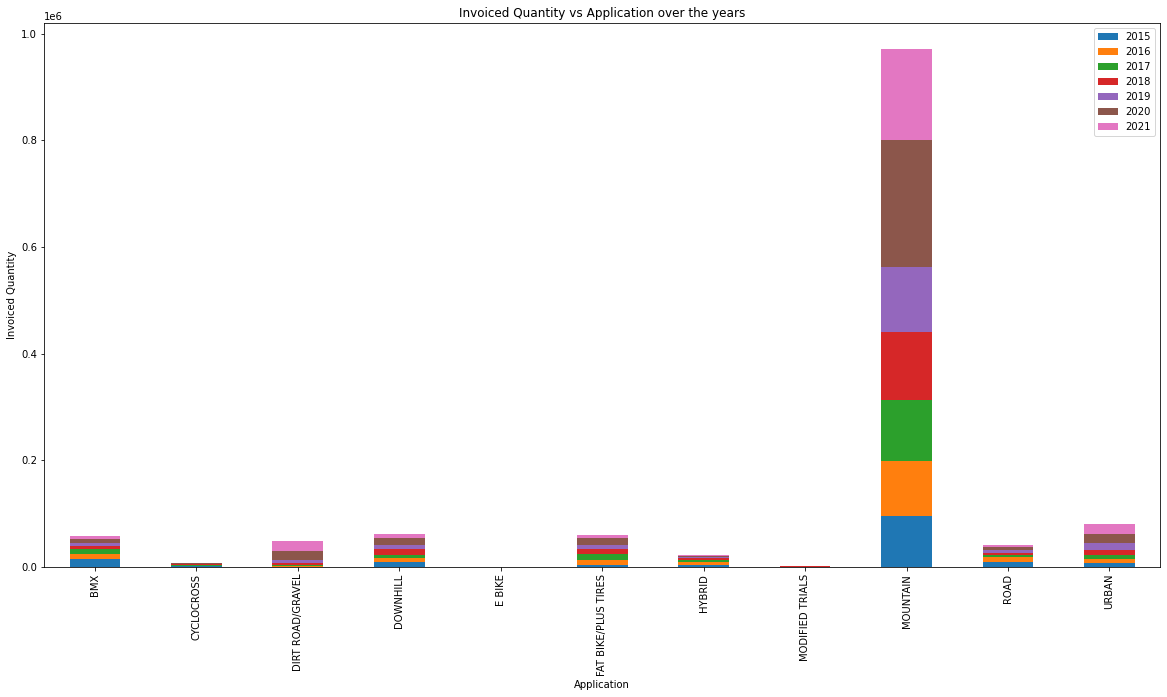

In [20]:
application_year_df.set_index("Application").plot(kind='bar',figsize=(20,10), stacked = True)

plt.title("Quantity Sold by Application")
plt.xlabel('Application')
plt.ylabel('Invoiced Quantity')

plt.legend(['2015',
            '2016',
            '2017',
            '2018',
            '2019',
            '2020',
            '2021',
           ])
plt.title("Invoiced Quantity vs Application over the years")
plt.savefig("Output/Invoiced Quantity vs Application over the years.png")
plt.show()

In [21]:
# group sales by for forecast

diameter_df = reduced_df.groupby(["Application","Diameter","Year","Month"],
                                   as_index = False)[["Application","Diameter",
                                                      "Year","Month",
                                                      "Invoiced Quantity"]].sum()

diameter_mountain_df = diameter_df.loc[diameter_df['Application'] == "MOUNTAIN"]

diameter_275_df = diameter_mountain_df.loc[diameter_df['Diameter'] == "27.5"]
diameter_29_df = diameter_mountain_df.loc[diameter_df['Diameter'] == "29"]
diameter_275_df = diameter_275_df[["Year","Month","Invoiced Quantity"]].reset_index(drop=True)
diameter_275_df = diameter_275_df.rename(columns=({"Invoiced Quantity":"27.5"}))
diameter_29_df = diameter_29_df[["Invoiced Quantity"]].reset_index(drop=True)
diameter_29_df = diameter_29_df.rename(columns=({"Invoiced Quantity":"29"}))
year_diameter_df = diameter_275_df.merge(diameter_29_df,
                                         how='outer', left_index=True, right_index=True)

year_diameter_df

,Year,Month,27.5,29
0,2015,01,676,1888
1,2015,02,2388,2996
2,2015,03,1457,4061
3,2015,04,1978,2598
4,2015,05,3478,5342
...,...,...,...,...
77,2021,06,4306,17983
78,2021,07,2879,15257
79,2021,08,2602,15301
80,2021,09,1682,5994


C:\Users\iamth\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\iamth\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-22-cdfd5bb2082f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc_diameter_1519_df["27.5 Forecast"] = fit_diameter_model_275.fittedvalues
<ipython-input-22-cdfd5bb2082f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

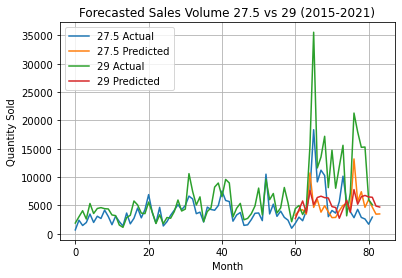

MSE: 23465694.35
MAE: 3503.2166666666667


<Figure size 432x288 with 0 Axes>

In [22]:
# Holt Winters Triple Exponential Smoothing forecasting

fc_diameter_df = year_diameter_df

# filter out only 2015-2019 for training data
fc_diameter_1519_df = fc_diameter_df.loc[(fc_diameter_df['Year'] == "2015")|
                                         (fc_diameter_df['Year'] == "2016")|
                                         (fc_diameter_df['Year'] == "2017")|
                                         (fc_diameter_df['Year'] == "2018")|
                                         (fc_diameter_df['Year'] == "2019"), :]

# 27.5 forecast
fit_diameter_model_275 = ETS(fc_diameter_1519_df["27.5"],
                             trend="mul",seasonal="mul", damped_trend=True,
                             seasonal_periods=12).fit()

fc_diameter_2021_275 = fit_diameter_model_275.forecast(24).round()

fc_diameter_1519_df["27.5 Forecast"] = fit_diameter_model_275.fittedvalues

fc_diameter_1519_df["27.5 Forecast"] = fc_diameter_1519_df["27.5 Forecast"].round()


# 29 forecast
fit_diameter_model_29 = ETS(fc_diameter_1519_df["29"],
                            trend="mul",seasonal="mul", damped_trend=True,
                            seasonal_periods=12).fit()

fc_diameter_2021_29 = fit_diameter_model_29.forecast(24).round()

fc_diameter_1519_df["29 Forecast"] = fit_diameter_model_29.fittedvalues

fc_diameter_1519_df["29 Forecast"] = fc_diameter_1519_df["29 Forecast"].round()

# plot the forecasted model
fc_diameter_df["27.5"].plot(legend=True, label="27.5 Actual")
fc_diameter_2021_275.plot(legend=True, label="27.5 Predicted")
fc_diameter_df["29"].plot(legend=True, label="29 Actual")
fc_diameter_2021_29.plot(legend=True, label="29 Predicted")
plt.title("Forecasted Sales Volume 27.5 vs 29 (2015-2021)")
plt.ylabel("Quantity Sold")
plt.xlabel("Month")
plt.grid('both')
plt.show()
# fc_diameter_1519_df["27.5 Forecast"].plot(legend=True, label="27.5 DES")
# fc_diameter_1519_df["29 Forecast"].plot(legend=True, label="29 DES")

plt.savefig("Output/Forecasted Diameter.png")

# mean squared error and mean average error
mse_test = mse(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])
mae_test = meanabs(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])

# append forecasted values onto onto model
fc_diameter_1521_275_df = pd.DataFrame({"27.5 Forecast":fc_diameter_1519_df["27.5 Forecast"].append(fc_diameter_2021_275)})
fc_diameter_1521_29_df = pd.DataFrame({"29 Forecast":fc_diameter_1519_df["29 Forecast"].append(fc_diameter_2021_29)})

# merge forecasted dataframe with actual sales data frame
fcmd_df = fc_diameter_df.merge(fc_diameter_1521_275_df, how='outer', left_index=True, right_index=True)
fcmd_df = fcmd_df.merge(fc_diameter_1521_29_df, how='outer', left_index=True, right_index=True)

fcmd_df.at[82,"Year"]= "2021"
fcmd_df.at[83,"Year"]= "2021"
fcmd_df.at[82,"Month"]= "11"
fcmd_df.at[83,"Month"]= "12"

print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")

In [23]:
# Group forecasts by year
fcmd_yr_df = fcmd_df.groupby(["Year"],
                           as_index = False)[["Year",
                                              "27.5", "27.5 Forecast",
                                              "29", "29 Forecast"]].sum()

fcmd_yr_df['29 Actual %'] = (fcmd_yr_df['29'] / (fcmd_yr_df['29'] + fcmd_yr_df['27.5']) * 100).round(1)
fcmd_yr_df['29 Predicted %'] = (fcmd_yr_df['29 Forecast'] / (fcmd_yr_df['29 Forecast'] + fcmd_yr_df['27.5 Forecast']) * 100).round(1)

fcmd_yr_df.to_csv("Output/diameter_forecast_by_year.csv", index = False)

fcmd_yr_df = fcmd_yr_df.set_index("Year")

fcmd_yr_df

,27.5,27.5 Forecast,29,29 Forecast,29 Actual %,29 Predicted %
Year,,,,,,
2015,29671.0,34017.0,44833.0,43532.0,60.2,56.1
2016,40405.0,42218.0,41380.0,40975.0,50.6,49.3
2017,47500.0,51920.0,57391.0,45250.0,54.7,46.6
2018,49531.0,63396.0,68764.0,66834.0,58.1,51.3
2019,44642.0,51162.0,66495.0,63831.0,59.8,55.5
2020,78576.0,54801.0,141842.0,64303.0,64.4,54.0
2021,42606.0,67273.0,118794.0,65602.0,73.6,49.4


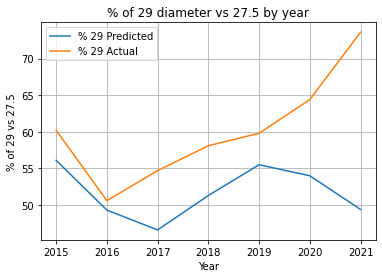

In [24]:
fcmd_yr_df['29 Predicted %'].plot(legend=True, label="% 29 Predicted")
fcmd_yr_df['29 Actual %'].plot(legend=True, label="% 29 Actual")

plt.xlabel('Year')
plt.ylabel('% of 29 vs 27.5')
plt.title('% of 29 diameter vs 27.5 by year')
plt.savefig("29v275.png")
plt.grid('both')
plt.show()

In [25]:
#chi testing data from combined_year
chi = {'year': ['2019', '2020'],
         'observed': [59.8,64.4], 'expected':[55.5,54.0]
        }

chi_df = pd.DataFrame(chi)

chi_df.to_csv("Output/chi_df.csv", index = False)

critical_value = st.chi2.ppf(q = 0.95, df = 2)

print(f"Critical Value = {critical_value}")
print(st.chisquare(chi_df['observed'], chi_df['expected']))

chi_df

Critical Value = 5.991464547107979
Power_divergenceResult(statistic=2.3361161161161177, pvalue=0.12640436210110415)


,year,observed,expected
0,2019,59.8,55.5
1,2020,64.4,54.0


In [26]:
# Secondary diameter group by specifically for plot below
diameter_df = reduced_df.groupby(["Application","Diameter","Year"],
                                   as_index = False)[["Application","Diameter","Year",
                                                      "Invoiced Quantity"]].sum()

diameter_mountain_df = diameter_df.loc[diameter_df['Application'] == "MOUNTAIN"]

diameter_mountain_df = diameter_mountain_df[["Diameter","Year","Invoiced Quantity"]]

years = diameter_mountain_df["Year"].unique()
diameters = {"Diameter": diameter_mountain_df["Diameter"].unique()}
diameter_year_df = pd.DataFrame(diameters)

for each in years:
    df = diameter_mountain_df.loc[diameter_mountain_df['Year'] == each]
    df = df[["Diameter","Invoiced Quantity"]]
    df = df.rename(columns={"Invoiced Quantity" : each})
    diameter_year_df = pd.merge(diameter_year_df, df, on="Diameter", how="left" )

# diameter_year_df

year_diameter_df = diameter_year_df.transpose()

year_diameter_df.columns=year_diameter_df.iloc[0]
year_diameter_df = year_diameter_df[1:]
year_diameter_df = year_diameter_df.rename(columns={"Diameter":"Year"})

year_diameter_df.to_csv("Output/year_diameter_df.csv", index = False)

year_diameter_df

Diameter,24,26,27.5,29
2015,496,20255,29671,44833
2016,574,20818,40405,41380
2017,481,9277,47500,57391
2018,918,8314,49531,68764
2019,1720,9522,44642,66495
2020,4499,13362,78576,141842
2021,2375,5849,42606,118794


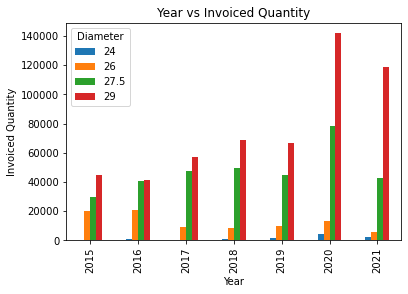

In [27]:
# plot quantity by diameter for each year
#for each in years:
    #plt.plot(diameter_year_df["Diameter"], diameter_year_df[each], label = each)
# diameter_year_df = diameter_year_df.astype(float)
# diameter_year_df.transpose().plot(kind='bar')

diameter_year_df.set_index("Diameter").transpose().plot(kind='bar')

plt.xlabel('Year')
plt.ylabel('Invoiced Quantity')
plt.title('Year vs Invoiced Quantity')
plt.savefig("Output/Year vs Invoiced Quantity.png")
plt.show()

In [28]:
#Percent change usind .pct_change()
pct_chng_diameter = diameter_year_df.set_index("Diameter").transpose().pct_change().fillna(0)

pct_chng_diameter.to_csv("Output/pct_chng_diameter.csv", index = False)

pct_chng_diameter

Diameter,24,26,27.5,29
2015,0.000000,0.000000,0.000000,0.000000
2016,0.157258,0.027796,0.361767,-0.077019
2017,-0.162021,-0.554376,0.175597,0.386926
2018,0.908524,-0.103805,0.042758,0.198167
2019,0.873638,0.145297,-0.098706,-0.032997
2020,1.615698,0.403277,0.760136,1.133123
2021,-0.472105,-0.562266,-0.457773,-0.162491


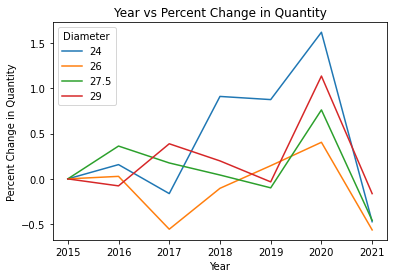

In [29]:
#figure of percent change
pct_chng_diameter.plot()
plt.xlabel('Year')
plt.ylabel('Percent Change in Quantity')
plt.title('Year vs Percent Change in Quantity')
plt.savefig("Output/Year vs Percent Change in Quantity.png")